# Aim
Checking if centroids of overlapping optima of local subgraphs also maximize graphs

## Basics

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt
#clustering
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt

2021-07-09 08:41:10,477- WARNING•	QuickBB solver is unavailable
2021-07-09 08:41:10,480- WARNING•	Tamaki solver is unavailable: No path /home/egupta/.local/lib/python3.7/site-packages/thirdparty/tamaki_treewidth


In [3]:
import torch

# Tranferability  Matrix for random subgraphs

In [4]:
## Old Code
#@title
from matplotlib import pyplot
from matplotlib import gridspec


def get_edge_contribution(graph, edge, gamma, beta):
    sim = qtensor.QtreeSimulator()
    composer = qtensor.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    return np.real(sim.simulate_batch(composer.circuit)[0])

def transferability_matrix(graphs, multistart=10, steps=100):
    sim = WithoutQAOASimulator(QtreeQAOAComposer)
    matrix_loss = np.zeros((len(graphs), len(graphs)))
    for i, donor in enumerate(graphs):
        print(f"{i + 1}/{len(graphs)}")
        for s in range(multistart):
            gamma, beta = [np.random.rand()], [np.random.rand()]
            params, loss = get_qaoa_params(donor, edge=(0,1), gamma=gamma, beta=beta, steps=steps)
            gamma_opt, beta_opt = params[0][0], params[1][0]
            print('donor loss ' + str(loss))
            for j, acceptor in enumerate(graphs):
                trloss = get_edge_contribution(acceptor, (0,1), *params)
                print('acceptor loss' + str(trloss))
                similarity = trloss*loss/np.sqrt(trloss**2 + loss**2 + 0.001)
                matrix_loss[i,j] += similarity
    return matrix_loss


def sub_all(d1, d2, draw=False):
    # returns a list of subgraphs of all graphs with nodes of the central edge having degree d1 and d2
    A = np.zeros((d1 + d2, d1 + d2))
    A[d1 + 1:, d1] = 1
    A[:d1 - 1, d1 - 1] = 1
    A[d1 - 1, :d1 - 1] = 1
    A[d1, d1 + 1:] = 1
    A[d1, d1 - 1] = 1
    A[d1 - 1, d1] = 1
    
    g = nx.from_numpy_matrix(np.array(A))

    g_list = [g]
    for i in range(min(d1, d2) - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d1 + 1))
    # relabel center edge as (0, 1)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d1 - 1, d1))
        if draw:
            nx.draw_kamada_kawai(g)
            plt.show()
    return g_list

In [5]:
## My Code
def get_qaoa_params(graph, edge=(0,1), gamma=[0.5], beta=[0.5], steps=50):
    loss_history, params_history = popt.qaoa_maxcut_torch(graph, gamma, beta,
                                                          ordering_algo='greedy',
                                                          Opt=torch.optim.RMSprop,
                                                          edge=edge,
                                                          opt_kwargs=dict(lr=0.002),
                                                          steps=steps,
                                                          pbar=False)
    best_ix = np.argmin(loss_history)
    return params_history[best_ix], loss_history[best_ix]

In [6]:
def subgraph_optimal_param_and_cost(graph, edge, p, seeds, steps):
    '''
    Optimize parameters of a subgraph, do so (seed) many times with random initial
    ized parameters

    Return: array of Results of (seed) many optimization runs and the index of 
    array corresponding to max energy
    '''
    results = []
    s = 0 #iterator
    max_energy = -1
    max_index = 0

    while s<seeds:
        gamma = [np.random.rand() for i in range(p)]
        beta = [np.random.rand() for i in range(p)]
        params, loss = get_qaoa_params(graph, edge=(0,1), gamma=gamma, beta=beta, steps=steps)
        gamma_opt, beta_opt = params[0], params[1]
        energy = (1-loss)/2
        result = [gamma_opt, beta_opt, energy]
        results.append(result)

        # comparing with max
        if energy >max_energy:
            max_index = s
            max_energy = energy
        s+=1
    max_result = results[max_index]
    return max_result

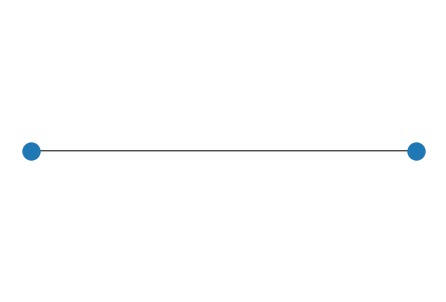

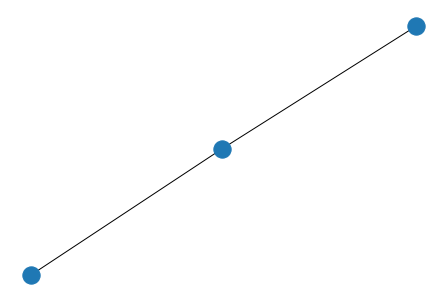

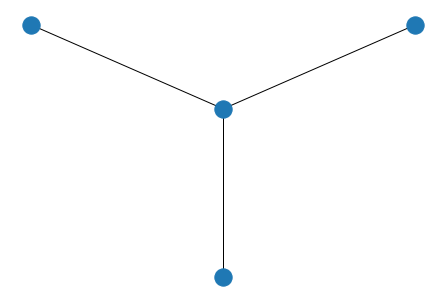

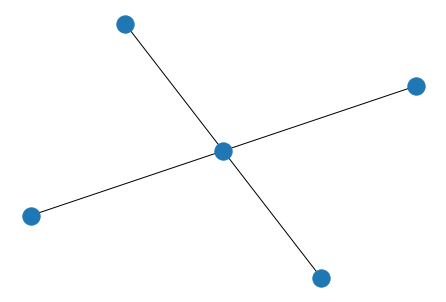

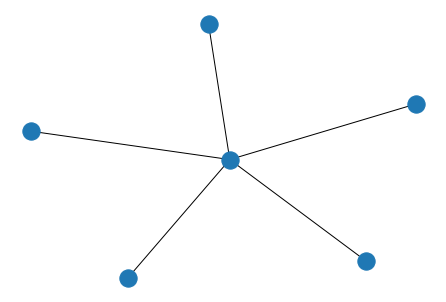

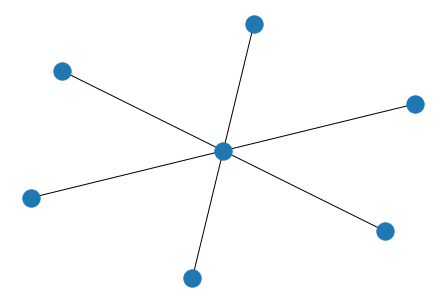

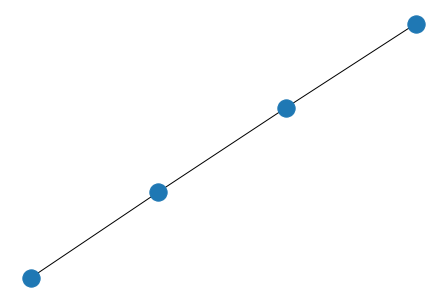

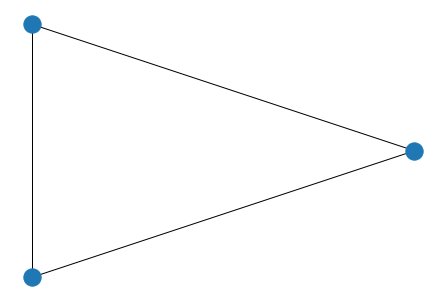

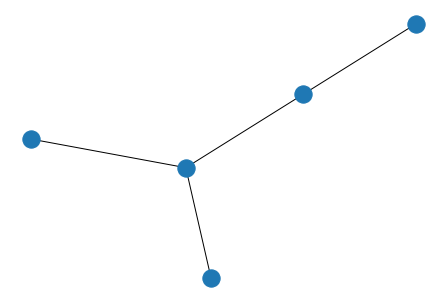

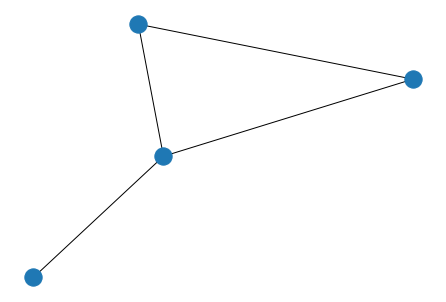

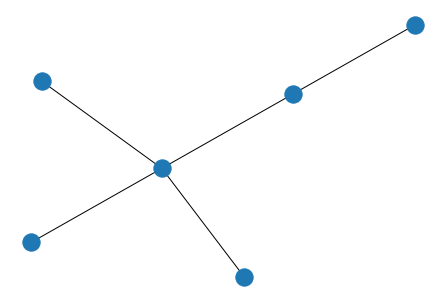

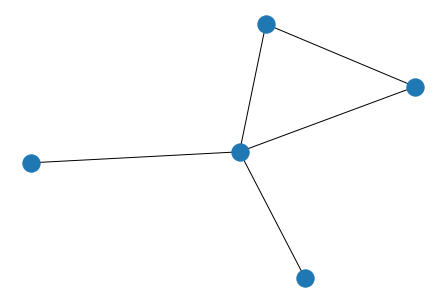

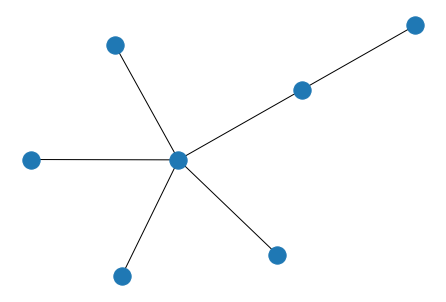

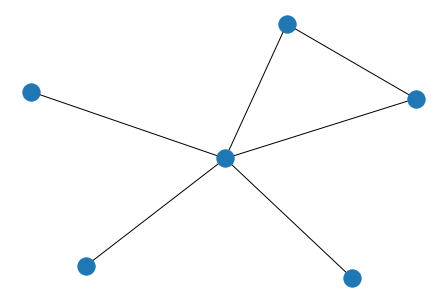

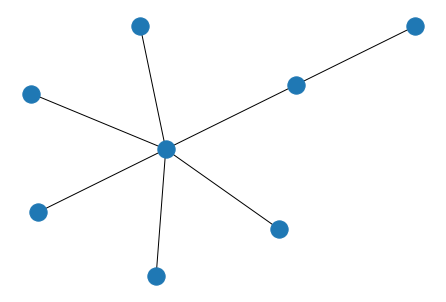

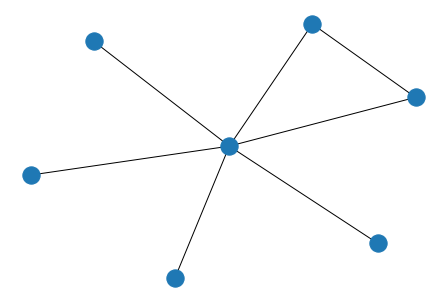

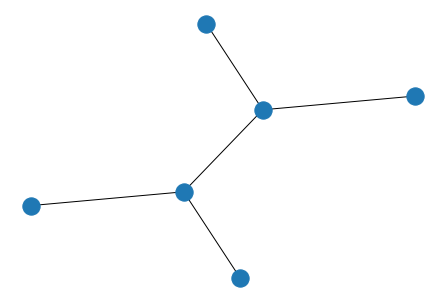

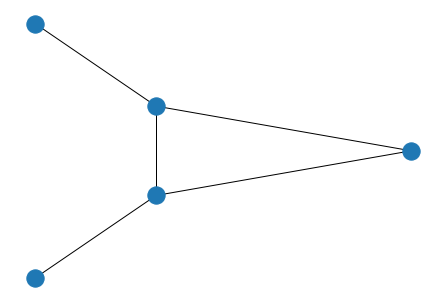

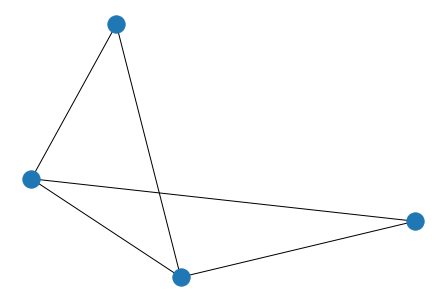

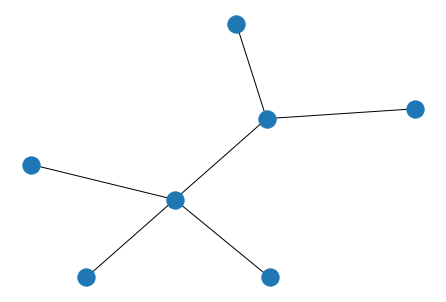

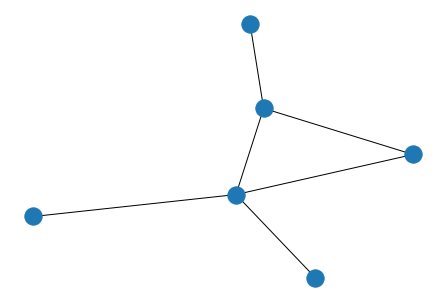

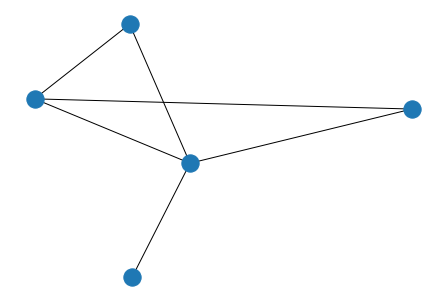

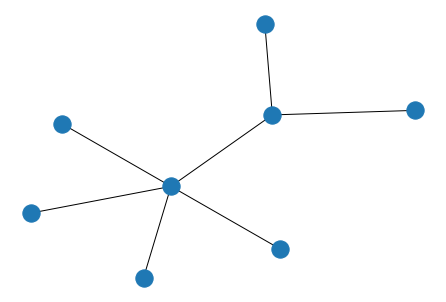

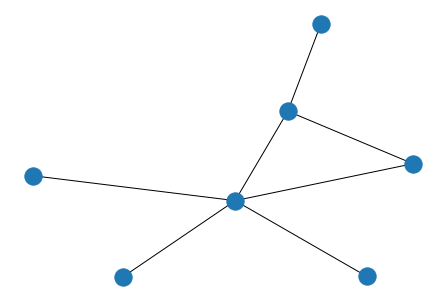

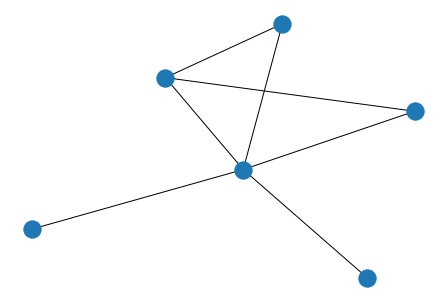

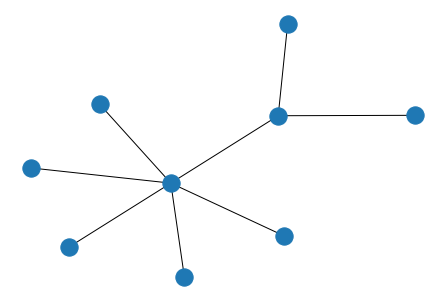

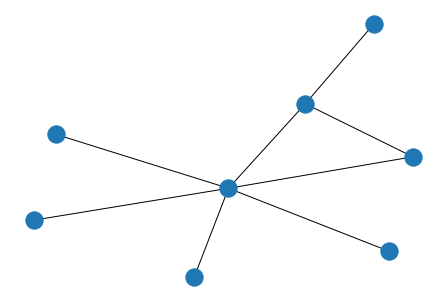

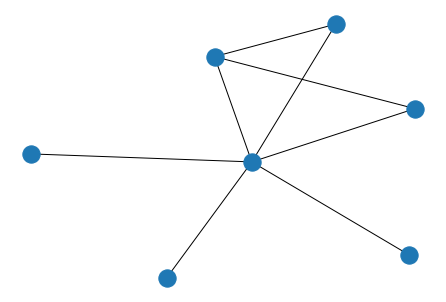

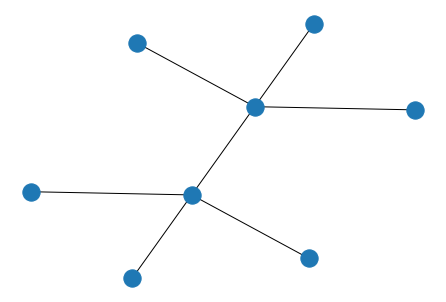

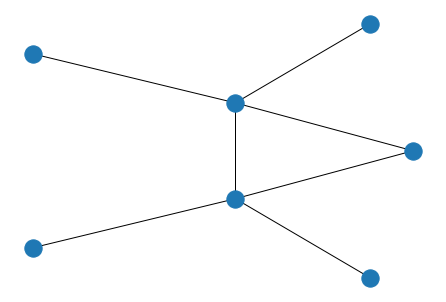

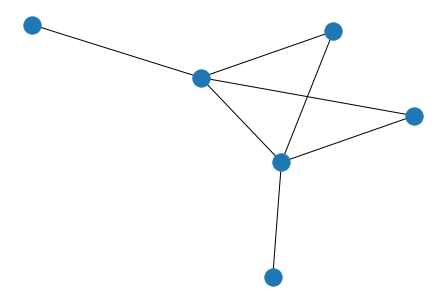

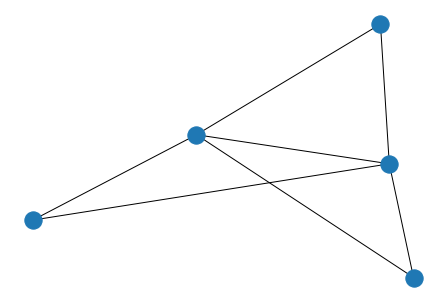

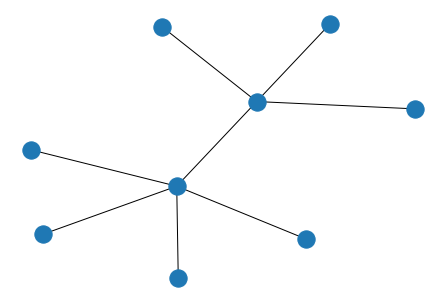

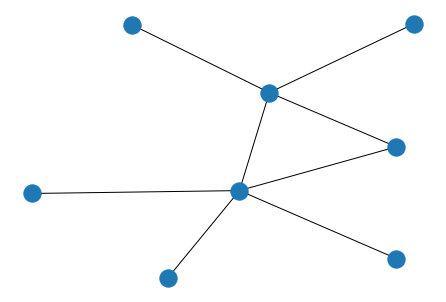

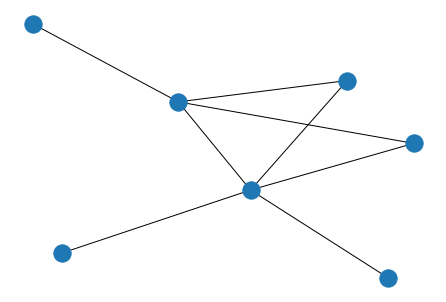

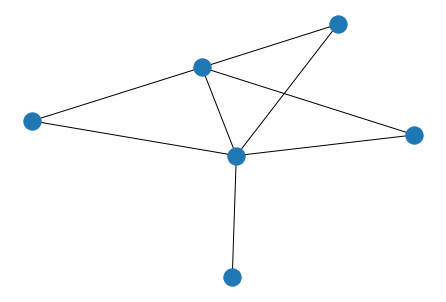

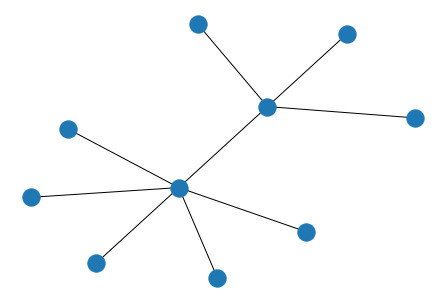

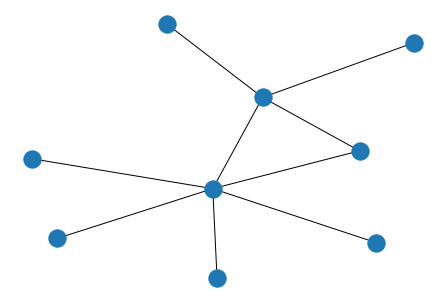

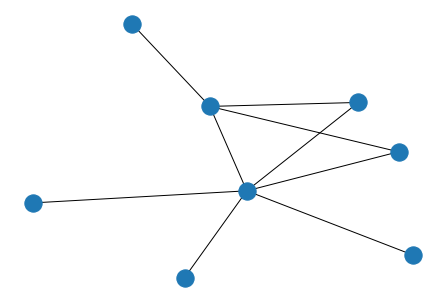

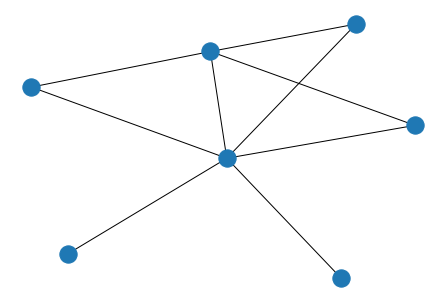

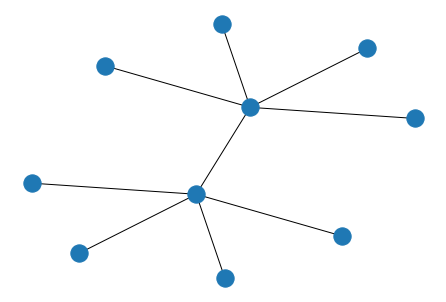

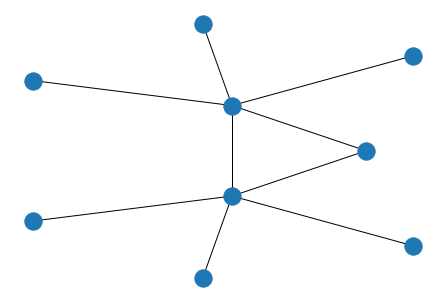

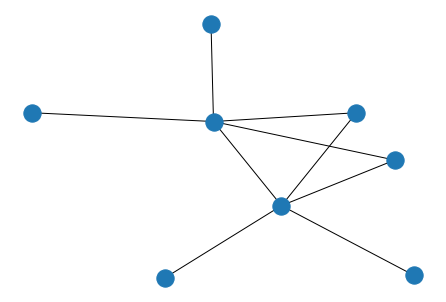

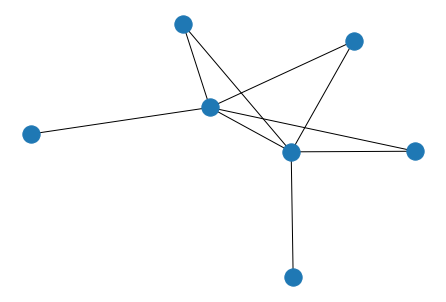

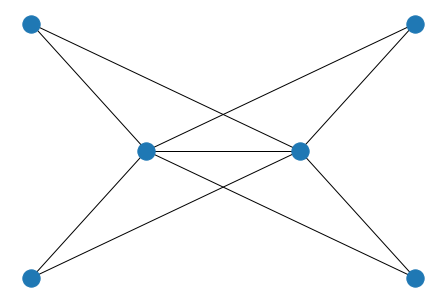

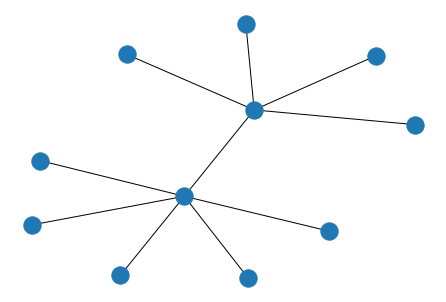

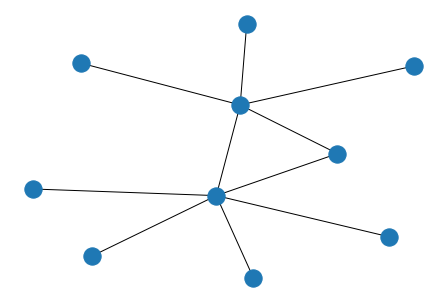

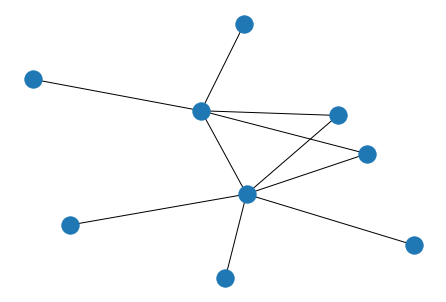

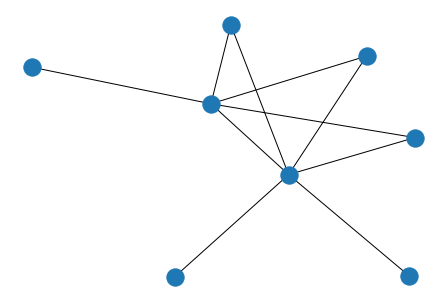

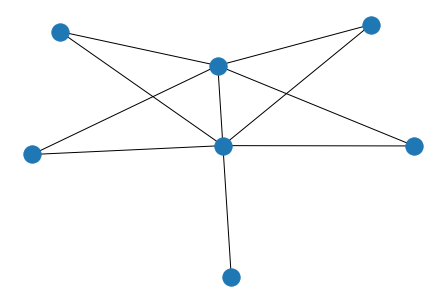

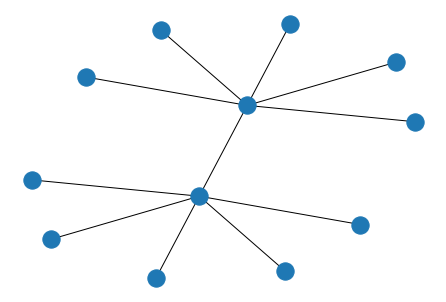

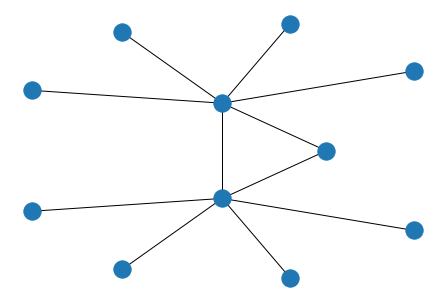

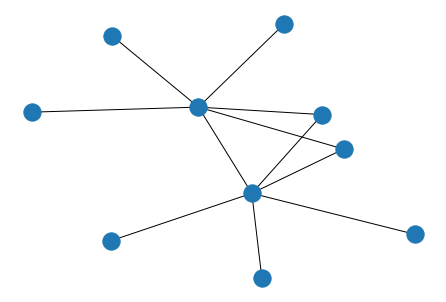

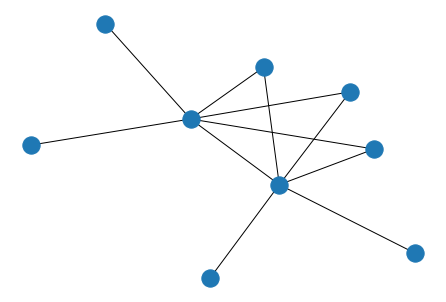

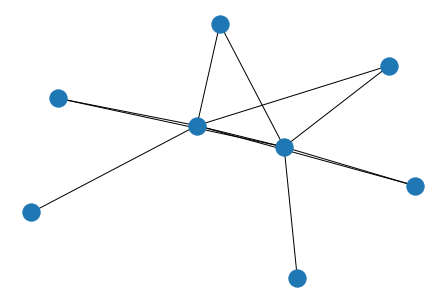

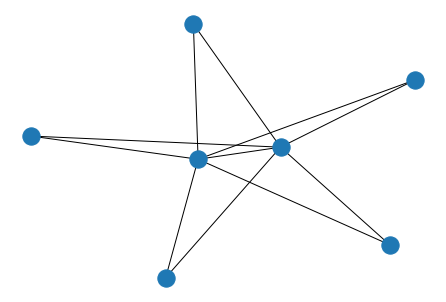

In [7]:
#generating all subgraphs first 
d_min = 1
d_max = 6
g_all = []
for i in range(d_min, d_max + 1):
    for j in range(i, d_max + 1):
        g_sub_ij = sub_all(i, j, draw=True)
        g_all += g_sub_ij

In [8]:
len(g_all)

56

In [9]:

def get_local_optima(subgraph,cutoff = 0.5, edge=(0,1), steps=50, multistarts =20):
    """
    Given a subgraph return those witin 10% of global
    """
    all_params = []
    all_energies = []
    for m in range(multistarts):
        
        p=1
        gamma = [np.random.rand() for i in range(p)]
        beta = [np.random.rand() for i in range(p)]
        loss_history, params_history = popt.qaoa_maxcut_torch(subgraph, gamma, beta,
                                                              ordering_algo='greedy',
                                                              Opt=torch.optim.RMSprop,
                                                              edge=edge,
                                                              opt_kwargs=dict(lr=0.002),
                                                              steps=steps,
                                                              pbar=False)
        energies_history = [(1-loss)/2 for loss in loss_history]
        
        all_params+=params_history
        all_energies+=energies_history
    
    #print(all_energies)
    best_index = np.argmax(all_energies)
    best_energy = float(all_energies[best_index])
    best_param = all_params[best_index]
    
    #storing data for local optima
    local_params= [best_param]
    local_energies = [best_energy]
    
    #add all local
    for i in range(len(all_energies)):
        energy = all_energies[i]
        params = all_params[i]
        
        if (abs(energy-best_energy)/best_energy)<cutoff:
            local_params.append(params)
            local_energies.append(energy)
    
        
    return local_params, local_energies

In [10]:
def fix_param(params):
    """
    Assuming gamma ranges from 0 to 1 and beta from 0 to 0.5 and both are preiodic
    """
    new_params = []
    for p in params:
        gamma = float(p[0])
        beta = float(p[1])
        gamma = gamma%1
        beta = beta%0.5
        new_params.append([gamma, beta])
    return new_params

In [11]:
import pandas as pd
from sklearn.cluster import KMeans

# Importing random graphs

In [12]:
g_data = []
with open('20NodeRandomData1.csv', 'r', newline = '') as s:
    spamreader = csv.reader(s, quotechar='|')
    for row in spamreader:
        new_row = [float(i) for i in row]
        g_data.append(new_row)

In [13]:
resi = []
with open('20NodeRandomGraph1.csv', 'r', newline = '') as g:
  spamreader = csv.reader(g, quotechar='|')
  for row in spamreader:
    resi.append(row)

#convert bunch of rows to matrices
n = int(len(resi)/20)
mat_list = []
for i in range(n):
  array = []
  for j in range(20):
    row = resi[i*20 +j]
    row = [float(k) for k in row]
    array.append(row)
  mat_list.append(array)

In [14]:
def mats_to_graphs(mat_list):
  """
  Given list of adjaceny matrix repr of graphs, converts to actual graphs
  """
  g_list = []
  for mat in mat_list:
    arr = np.array(mat)
    G = nx.convert_matrix.from_numpy_matrix(arr)
    g_list.append(G)
  return g_list

In [15]:
g_list = mats_to_graphs(mat_list)

In [16]:
len(g_data)

55

In [17]:
len(g_list)

55

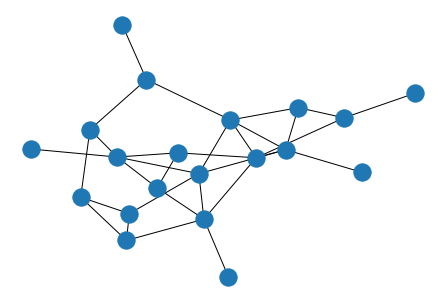

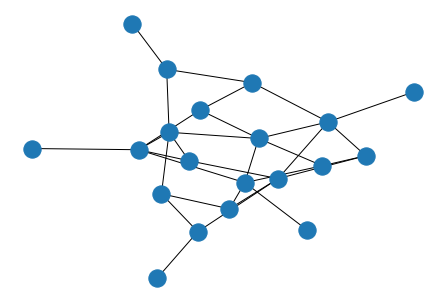

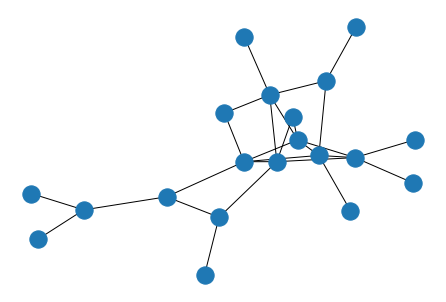

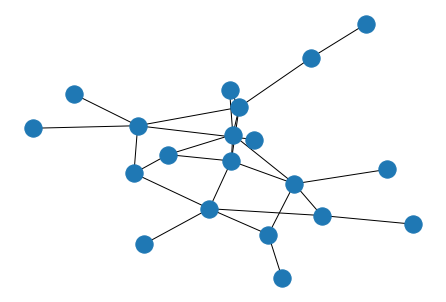

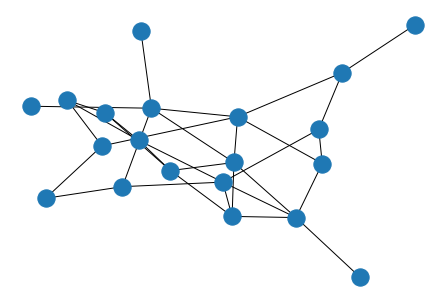

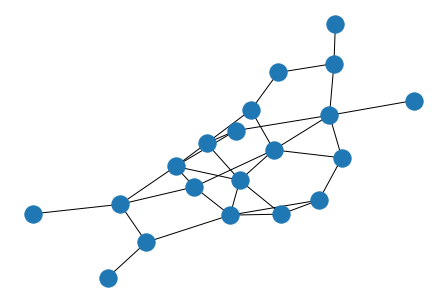

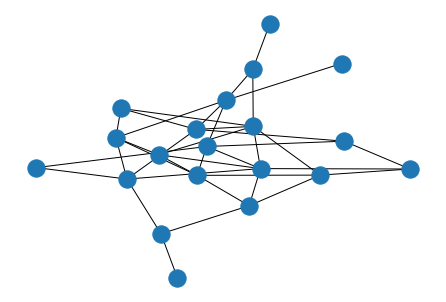

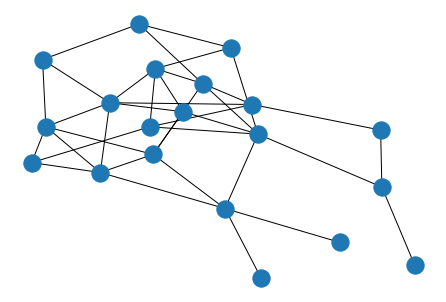

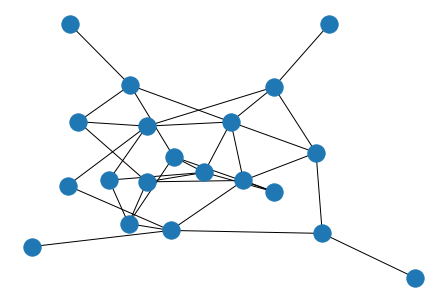

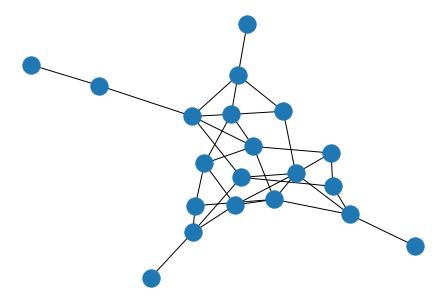

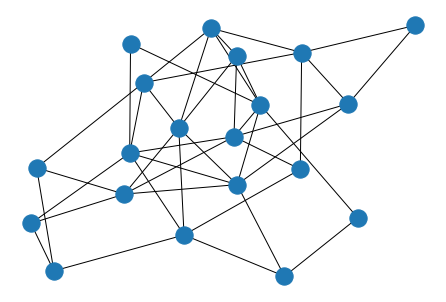

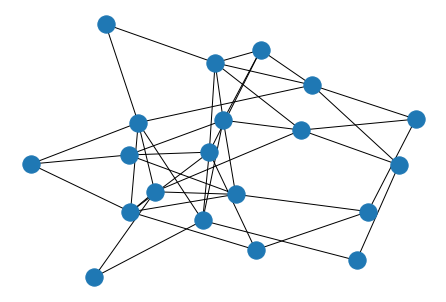

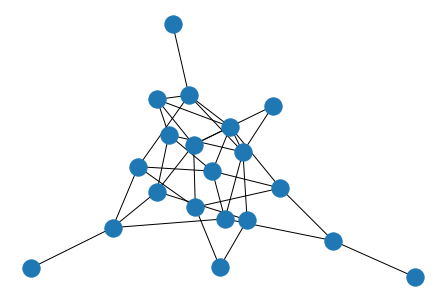

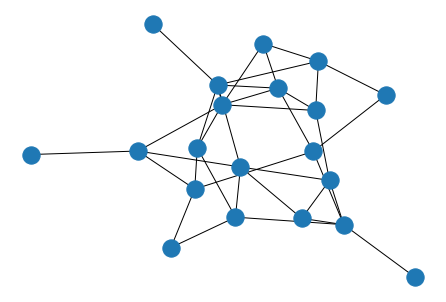

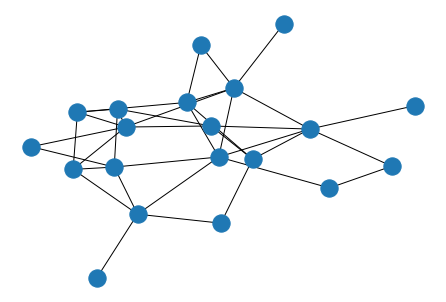

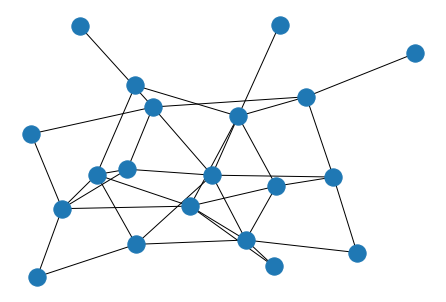

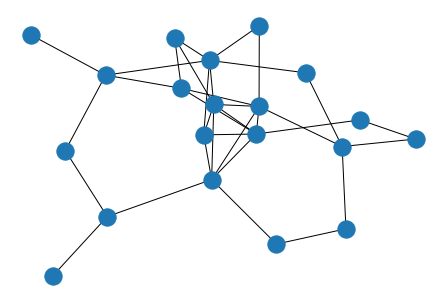

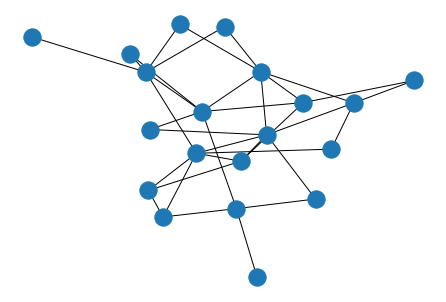

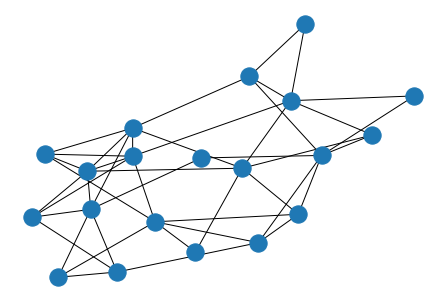

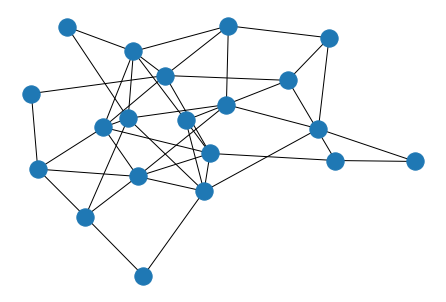

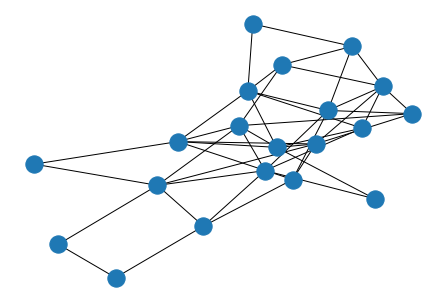

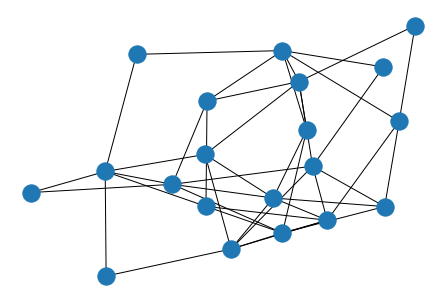

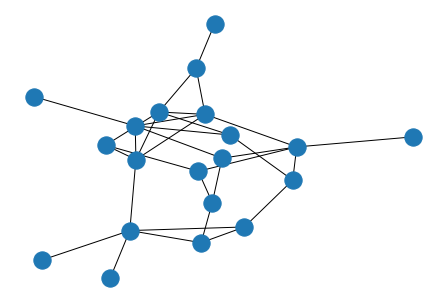

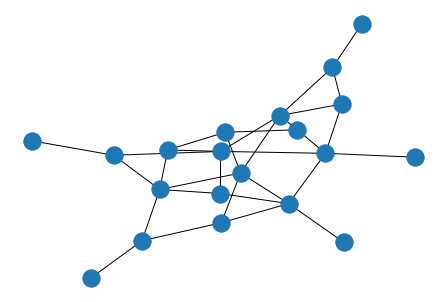

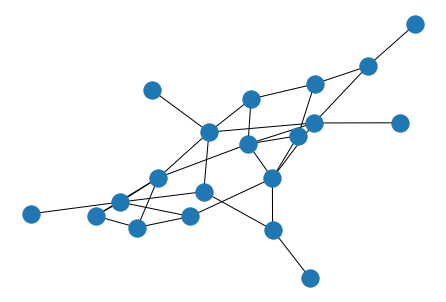

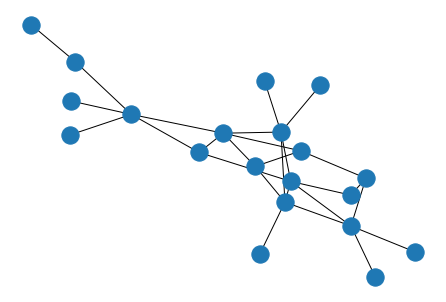

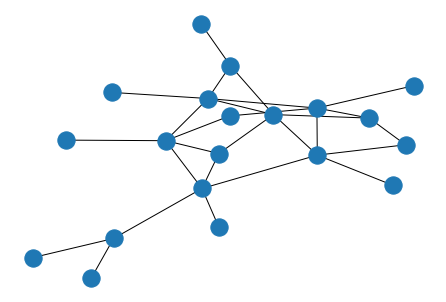

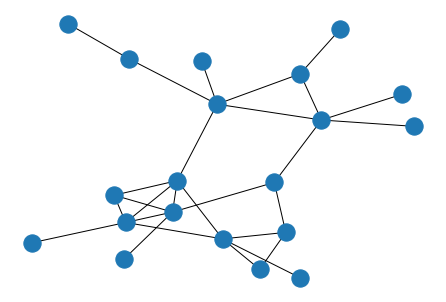

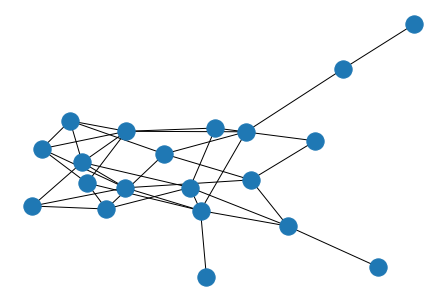

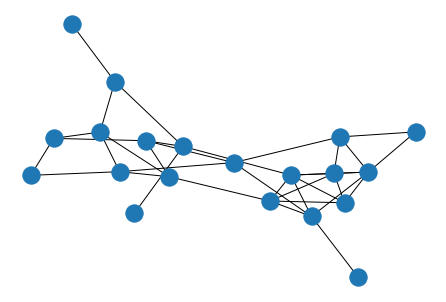

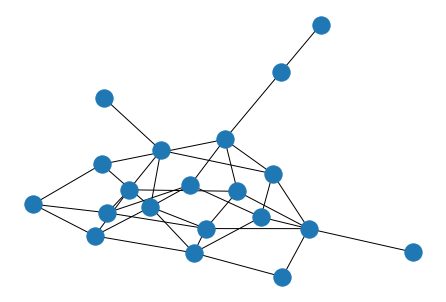

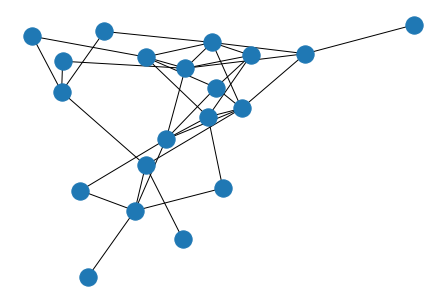

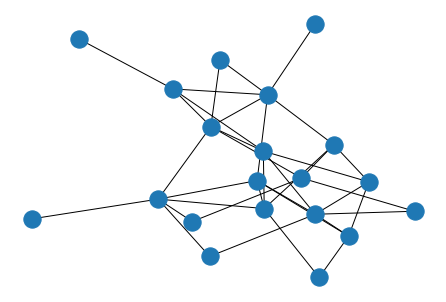

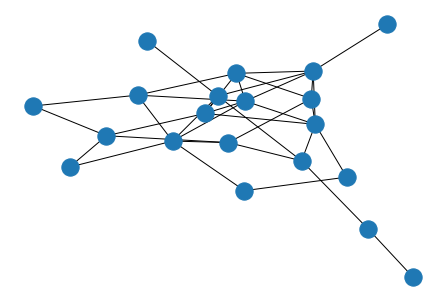

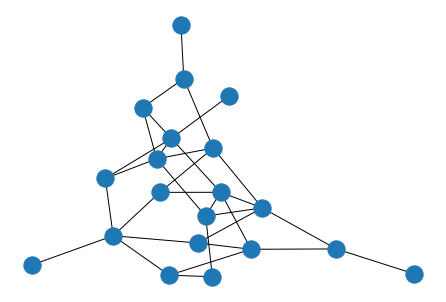

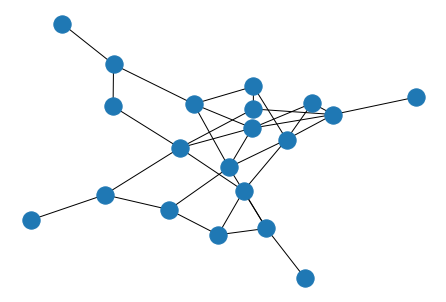

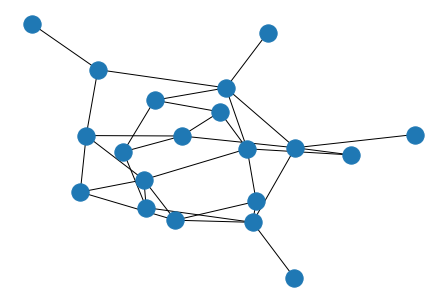

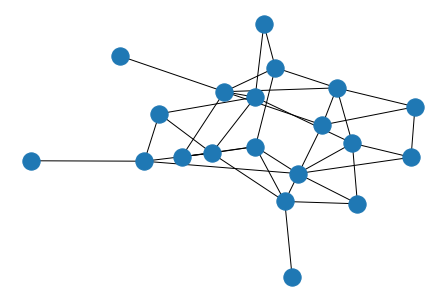

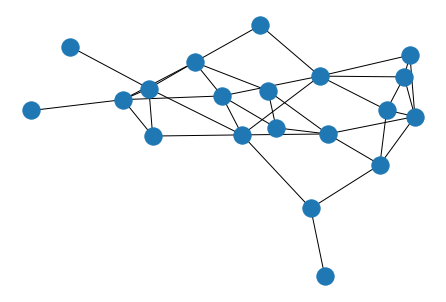

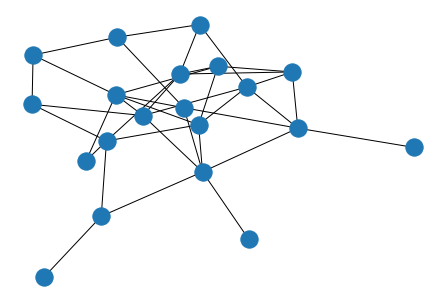

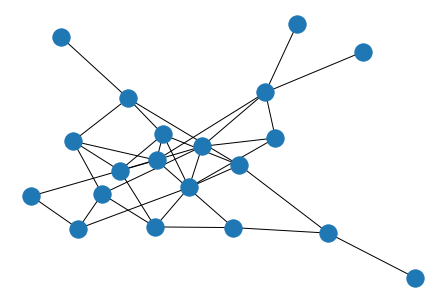

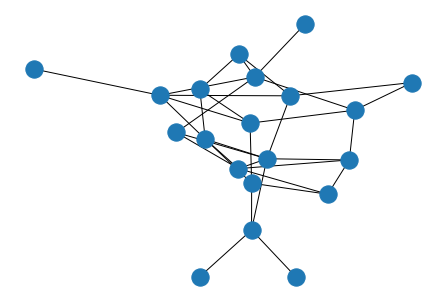

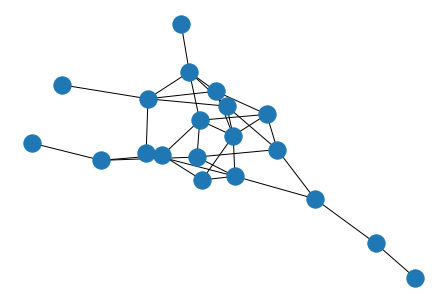

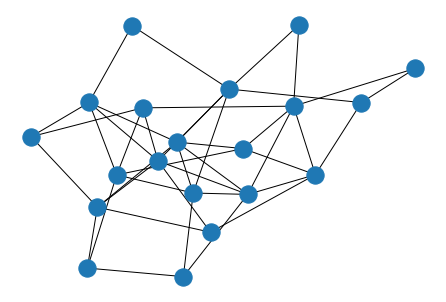

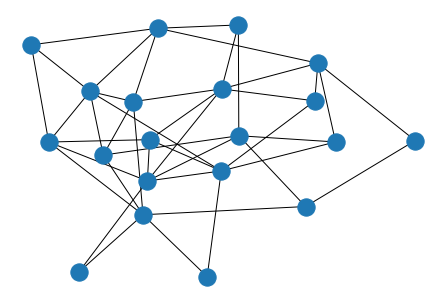

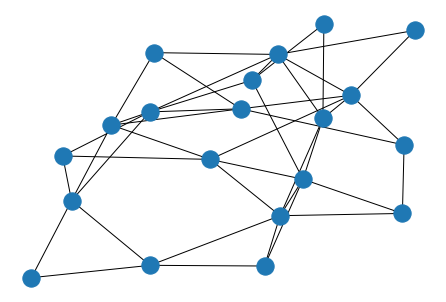

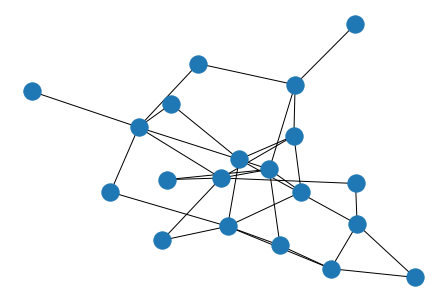

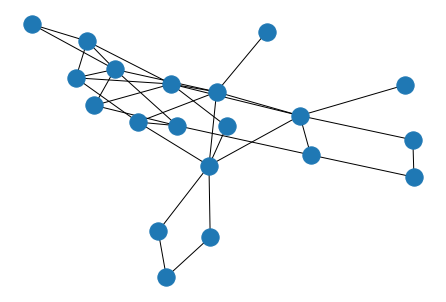

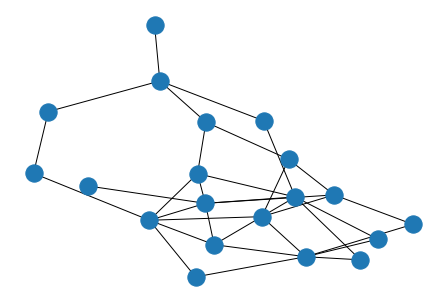

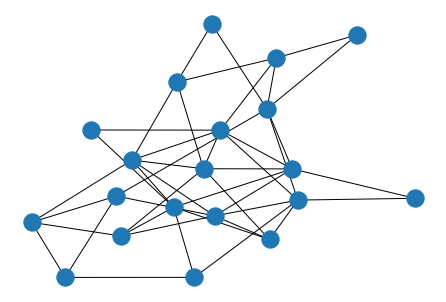

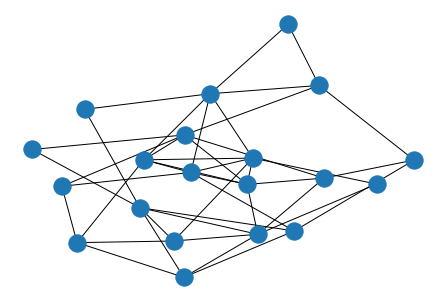

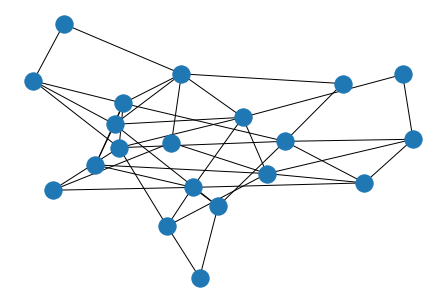

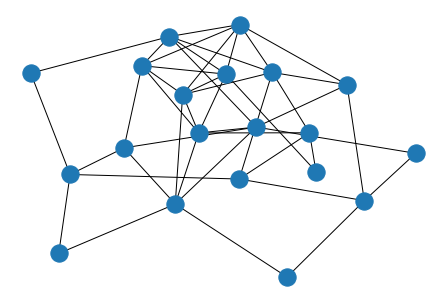

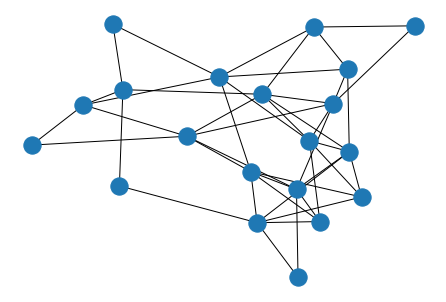

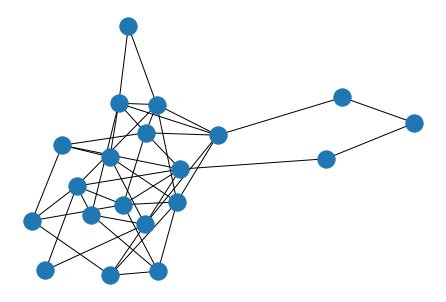

In [18]:
for i in g_list:
  nx.draw(i)
  plt.show()

# Doing the k means thing for all subgraphs
Assuming 4 clusters for all

Getting data from July 8 file

In [46]:
centers = [[0.37495592455418414, 0.24998826952466746],
 [0.12498338805473858, 0.750093454935025],
 [0.3748830576885996, 0.2558392745938469],
 [0.37500648414063614, 0.24369947422461882],
 [0.12497097102408494, 0.8333346553135789],
 [0.3749655557457262, 0.16662208117348565],
 [0.37514371204376185, 0.1709218004345881],
 [0.12508058297919872, 0.8289685894365171],
 [0.3748842254201723, 0.3482828063428106],
 [0.1249758842891087, 0.8480026642858295],
 [0.1249695525238818, 0.6517892500294866],
 [0.37499480579614997, 0.1514675239437882],
 [0.37484944704596396, 0.2501520863016663],
 [0.12499036904274005, 0.7498148563584615],
 [0.12500719195033633, 0.7434392859961115],
 [0.37549289479488257, 0.2565985885335173],
 [0.37499602318813197, 0.25007145113333384],
 [0.12496004103752198, 0.7500964579820935],
 [0.1250320990778965, 0.7424378705268003],
 [0.37506100756896543, 0.24244742608956385],
 [0.12492753722452037, 0.7498211776848521],
 [0.3749574168184436, 0.24988558062385907],
 [0.3749804888468453, 0.25735608269186633],
 [0.12503240805549096, 0.7422604429034092],
 [0.37504825268284686, 0.625081325938353],
 [0.3750213751833779, 0.12507878999087418],
 [0.12493809762339905, 0.3750188885941406],
 [0.1249907248909905, 0.8749860407485093],
 [0.40202406009516656, 0.0980204606486465],
 [0.40199643935453355, 0.597983655960402],
 [0.0979225076464193, 0.9019507429994962],
 [0.09813733616860629, 0.4021483033764449],
 [0.37496500827068124, 0.11080724975062078],
 [0.12501930064546127, 0.8893468792820457],
 [0.3785978184843606, 0.11072497594762937],
 [0.3748423572452293, 0.10882031301125061],
 [0.21115708070642844, 0.34424203478298415],
 [0.28888883716914415, 0.6557205646545686],
 [0.29333579570976726, 0.6563614477816317],
 [0.20610353093722772, 0.3437333302251225],
 [0.1250707657512749, 0.39766786068512416],
 [0.12500098462457565, 0.897706760666764],
 [0.37495299329326187, 0.10244831210614858],
 [0.3749633748772271, 0.6024101066257065],
 [0.10418917164354813, 0.4088261462614204],
 [0.10419787337280903, 0.9087326665516704],
 [0.3957114788353583, 0.0911994467117101],
 [0.3958378281693399, 0.5912724476270885],
 [0.37498791345552623, 0.09666891731409466],
 [0.12498177638661723, 0.9032499934980385],
 [0.1205027472782643, 0.903269056310045],
 [0.37496333536894433, 0.09978304922148762],
 [0.10638519803711569, 0.9104128603470045],
 [0.39357566018891066, 0.08965313186689783],
 [0.10604914119268977, 0.9067360188098668],
 [0.392989957955346, 0.0864765427228234],
 [0.37493223822355815, 0.09268862100148312],
 [0.37502784737640626, 0.5926301845491679],
 [0.1249598607326194, 0.9073258403575872],
 [0.12504391018919792, 0.40739343236733483],
 [0.1083049807763754, 0.9108834819861512],
 [0.3916962445911576, 0.08906401875516962],
 [0.391675138739653, 0.5889740749373469],
 [0.10829470492587007, 0.41096191545028277],
 [0.37508211450930523, 0.4020826286316501],
 [0.12492453220888008, 0.9020217603154749],
 [0.12492153355413002, 0.597919956034525],
 [0.3749881996036548, 0.09792880041941016],
 [0.10468317569277924, 0.5872913442844897],
 [0.3952611654110557, 0.41267571747800236],
 [0.10471905506731133, 0.912680983085546],
 [0.39535971761399513, 0.08736320871261549],
 [0.41015658204176547, 0.42180524332446795],
 [0.08994813936731721, 0.5782426116129835],
 [0.41003882287030924, 0.0781739992200246],
 [0.0898095106124856, 0.921722375279663],
 [0.12513394994472052, 0.9095972386391162],
 [0.3749485086722093, 0.09041110378642436],
 [0.123716578765988, 0.9094985825005598],
 [0.12806830661637453, 0.9093589697565351],
 [0.10690159871799246, 0.9169501110338071],
 [0.39311173371297015, 0.08302177927840754],
 [0.10762206788944141, 0.9192840203210927],
 [0.10588423656299702, 0.9142243281006812],
 [0.23176231906412356, 0.6099630236791062],
 [0.2680655891433883, 0.39001598166024765],
 [0.22617402133242837, 0.6103373231558965],
 [0.237295955796785, 0.609641561779795],
 [0.12499876464542051, 0.5850895917304602],
 [0.37500845874783495, 0.0851140413131729],
 [0.1249916358924617, 0.9148781093111022],
 [0.3749586469406443, 0.41490970054596504],
 [0.1085975168492133, 0.9200435722252298],
 [0.391336470559872, 0.42000779243536634],
 [0.39144435583024084, 0.08002042774610907],
 [0.10850918794461659, 0.5799724763769347],
 [0.09475189248773347, 0.5743943864528468],
 [0.40516814561090336, 0.074350395317132],
 [0.4052765594910912, 0.42563726757866294],
 [0.09471932099880528, 0.9255019692687323],
 [0.12497813080201176, 0.9188419199440867],
 [0.37496909812964135, 0.08115068513437207],
 [0.3777741396876231, 0.08118274256791186],
 [0.128752981312573, 0.9191280961968002],
 [0.39072154379553253, 0.08094506069189983],
 [0.10999052084542825, 0.922439623520106],
 [0.39001591433902727, 0.07758352669544383],
 [0.11378819896624626, 0.9227230064570906],
 [0.2988511640170099, 0.4034084509179464],
 [0.20111560657216354, 0.5965941465923994],
 [0.20730085143198565, 0.5955623698731264],
 [0.1951202585779387, 0.5977380131853037],
 [0.3749888417855992, 0.5833730688951548],
 [0.12502533539211336, 0.4166430269670953],
 [0.12507088017419277, 0.9166614188954714],
 [0.3749600386393447, 0.08331650558121195],
 [0.3912113144800151, 0.578048839390461],
 [0.108666905871551, 0.9219371912417222],
 [0.10868598738985455, 0.4219714650032043],
 [0.39131889816428855, 0.07802914030638852],
 [0.40509053788216154, 0.07257291988137515],
 [0.40494108717635374, 0.5725274752255464],
 [0.09503706789973362, 0.9274135307744377],
 [0.09508001904871166, 0.42741416884051814],
 [0.08449203004076186, 0.43423692017646986],
 [0.4157181419153224, 0.06593195336704177],
 [0.0843794267354048, 0.934192681898806],
 [0.4155998491004659, 0.565839480804304],
 [0.12500680330896274, 0.9215571240396201],
 [0.37508036308445303, 0.07844247558020007],
 [0.1214838192931243, 0.9216364970696825],
 [0.37252307578369465, 0.07851173071949585],
 [0.38988440669100877, 0.07444705266732643],
 [0.11005720930291385, 0.9255234365130383],
 [0.3902814381006288, 0.07763153968787762],
 [0.11392719257209044, 0.9255975203381643],
 [0.2661595866506305, 0.590497311327115],
 [0.23395233749062666, 0.40950116443809936],
 [0.25976464091515056, 0.590090682311934],
 [0.27261718666111984, 0.5908542529300408],
 [0.26143962011392063, 0.5974590804380941],
 [0.23846897601404043, 0.40252570381012936],
 [0.23328709845932635, 0.40231754344243287],
 [0.24398936174417796, 0.4027442341310936],
 [0.12502980559203866, 0.42524819801664926],
 [0.12502465427426626, 0.9252745579444064],
 [0.37499315617253215, 0.07474702775622072],
 [0.3750869379685636, 0.5747266389625045],
 [0.3888429886984958, 0.07176075126650266],
 [0.1111508650704402, 0.4282406981255151],
 [0.38885284343568627, 0.5717500100926631],
 [0.11127795441812002, 0.9282201779823711],
 [0.09866268435350964, 0.4316448416075768],
 [0.40127028563677447, 0.06832573304856665],
 [0.09871886212537903, 0.9316249780518469],
 [0.40124474872419746, 0.5684078172872229],
 [0.411798694553162, 0.5635450257114852],
 [0.08817906992078398, 0.9364858763835613],
 [0.4117399852474536, 0.06351966394908742],
 [0.08816929634995146, 0.4364422301239095],
 [0.3750334572790459, 0.4261845747250619],
 [0.1249473406347334, 0.9262089143333652],
 [0.12504083534767324, 0.5737801185315671],
 [0.3748944239756322, 0.07378479495839219],
 [0.3887809993984139, 0.4293269962931411],
 [0.11117654444823064, 0.9292844132072133],
 [0.38870075850050934, 0.07066566460495421],
 [0.11115042937932512, 0.5706577524014392],
 [0.4010892777875586, 0.43282713002488776],
 [0.09877789667023137, 0.5672508970261388],
 [0.4011384906504415, 0.06723858021211482],
 [0.09878917922541022, 0.9327331459228547],
 [0.08836035979648676, 0.9373622391235346],
 [0.4115236346824045, 0.0625258577927833],
 [0.08852162971952052, 0.5625413014922526],
 [0.4116646545886431, 0.43734141899589235],
 [0.419744631913732, 0.4426608632881746],
 [0.08024451630994378, 0.942643118980848],
 [0.4197480062025818, 0.057414150563610655],
 [0.0806293638026134, 0.5571331608490864],
 [0.12511834975642686, 0.9296725805314174],
 [0.3750549232672431, 0.07025214477139291],
 [0.37150412797927856, 0.07029998317360897],
 [0.12259582281112671, 0.9295652104275559],
 [0.11208553991617828, 0.9321585429517665],
 [0.38783389619437536, 0.06784727139758784],
 [0.11672115325927734, 0.9322233395650985],
 [0.39010104665192213, 0.06780848892465746],
 [0.40150749322139834, 0.06510886875065891],
 [0.10033315887717012, 0.9350092865374295],
 [0.3977872102647212, 0.06497271846275077],
 [0.399664679203436, 0.06505145895225534],
 [0.23991094180770206, 0.5810162680908366],
 [0.26009246564882704, 0.41898592377425686],
 [0.25518883019685745, 0.419154089476381],
 [0.2454079246442569, 0.580834844394734],
 [0.24178894089930025, 0.5892323833523391],
 [0.25813255757036213, 0.41079446808494213],
 [0.2633360064475335, 0.4106302626222093],
 [0.24674982974926632, 0.5890357395013173],
 [0.37512517957459957, 0.5669413565832465],
 [0.3749884661997082, 0.06693704275527246],
 [0.1250759252418177, 0.9330506322722876],
 [0.12512960898007344, 0.4330613892085453],
 [0.38708422170839507, 0.5649144329979207],
 [0.11289108651078264, 0.9350747350466371],
 [0.3871729047802539, 0.06492134721358278],
 [0.11293646221318639, 0.4350745046172934],
 [0.39830393100432215, 0.06261183532483827],
 [0.3983282040867164, 0.5626326920014109],
 [0.10172526911797153, 0.9373850088123892],
 [0.10177916298512749, 0.43744601239692904],
 [0.40836591700562247, 0.559391189273749],
 [0.4083758575990053, 0.05939532189069563],
 [0.09173939026928371, 0.44061655684057704],
 [0.09174924840529927, 0.9405502688481584],
 [0.08336800602561481, 0.944576180984563],
 [0.41683127224242345, 0.05551855489104274],
 [0.4166295022903247, 0.5554278554128752],
 [0.08335562559622509, 0.44450684504795746],
 [0.4233918708943686, 0.051468759992873925],
 [0.07657096349911463, 0.44855817564114914],
 [0.07667037434115936, 0.9486244239278087],
 [0.42330289025419965, 0.5513954181614932]]

In [47]:
len(centers)

224

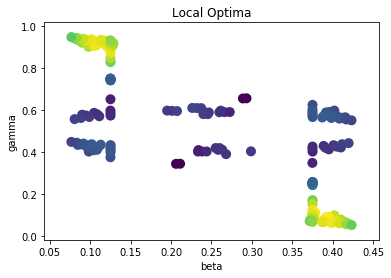

In [48]:
gamma = [float(centers[i][1]) for i in range(len(centers))]
beta = [float(centers[i][0]) for i in range(len(centers))]

#cm = plt.cm.get_cmap('Reds')

#plt.scatter(beta, gammafrom scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde

fig = plt.figure(figsize = (6,4))
x =beta
y = gamma

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# fig, ax = plt.subplots()
plt.scatter(x, y, c=z, s=100, edgecolor='')
plt.xlabel("beta")
plt.ylabel("gamma")
plt.title('Local Optima')
plt.show()

In [49]:
#Finding clusters from the above overlapping local optima plot

overlapping_centers=[]

gamma = [float(centers[i][1]) for i in range(len(centers))]
beta = [float(centers[i][0]) for i in range(len(centers))]
df = pd.DataFrame({'x': beta, 'y':gamma})
kmeans = KMeans(n_clusters = 8)
kmeans.fit(df)
labels = kmeans.predict(df)
sub_centers = kmeans.cluster_centers_
for row in sub_centers:
    overlapping_centers.append(row)

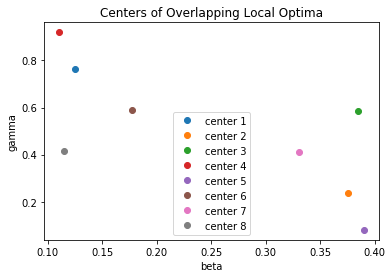

In [50]:
#plotting 
x = [i[0] for i in overlapping_centers]
y = [i[1] for i in overlapping_centers]
for i in range(len(x)):
    plt.plot(x[i],y[i], marker = "o", linestyle = "", label = "center " + str(i+1))
plt.xlabel("beta")
plt.ylabel("gamma")
plt.title('Centers of Overlapping Local Optima')
plt.legend()
plt.show()

In [51]:
overlapping_centers

[array([0.12499829, 0.7655852 ]),
 array([0.37502655, 0.23578019]),
 array([0.38496972, 0.5840616 ]),
 array([0.11061734, 0.91970973]),
 array([0.38978625, 0.08037869]),
 array([0.17728885, 0.58903538]),
 array([0.33075605, 0.41290091]),
 array([0.11503372, 0.41595895])]

In [52]:
overlapping_centers_ratios = []

for center in overlapping_centers:
    center_ratios = []
    for g_ind in range(len(g_list)):
        
        #loss = get_edge_contribution(graph = g_all[g_ind], edge = (0,1), gamma = [center[1]], beta = [center[0]])
        #notice index of gamma and beta are reversed because thats how its plotted above
        
        e = QAOA_energy(g_list[g_ind], gamma = [center[1]],beta = [center[0]])
        #print(e)
        
        max_e = g_data[g_ind][2]
        #print(max_e)
        ratio = e/max_e
        
        center_ratios.append(ratio)
    overlapping_centers_ratios.append(center_ratios)

In [53]:
for r in range(len(overlapping_centers_ratios)):
    for c in range(len(overlapping_centers_ratios[r])):
        overlapping_centers_ratios[r][c] = float(overlapping_centers_ratios[r][c] )

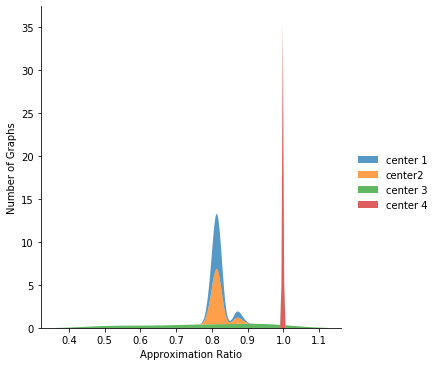

In [67]:
# importing iris dataset from the library
df = pd.DataFrame({'center 1': overlapping_centers_ratios[0],
                   'center2': overlapping_centers_ratios[1],
                   'center 3': overlapping_centers_ratios[2] ,
                  'center 4': overlapping_centers_ratios[3],
#                    'center 5': overlapping_centers_ratios[4],
#                    'center 6': overlapping_centers_ratios[5] ,
#                   'center 7': overlapping_centers_ratios[6],
#                    'center 8': overlapping_centers_ratios[7],
                 })
  
# plotting histogram and density plot for 
# sepal width using distplot() by setting color
sns.displot(df,kind="kde", multiple="stack", linewidth=0)#, #hist_kws={"edgecolor": 'white'})



plt.xlabel("Approximation Ratio")
plt.ylabel("Number of Graphs")
plt.show()

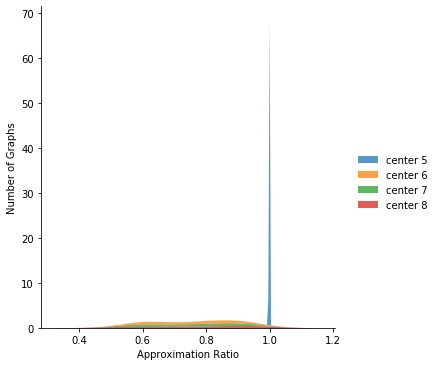

In [68]:
# importing iris dataset from the library
df = pd.DataFrame({
#     'center 1': overlapping_centers_ratios[0],
#                    'center2': overlapping_centers_ratios[1],
#                    'center 3': overlapping_centers_ratios[2] ,
#                   'center 4': overlapping_centers_ratios[3],
                   'center 5': overlapping_centers_ratios[4],
                   'center 6': overlapping_centers_ratios[5] ,
                  'center 7': overlapping_centers_ratios[6],
                   'center 8': overlapping_centers_ratios[7]
                 })
  
# plotting histogram and density plot for 
# sepal width using distplot() by setting color
sns.displot(df,kind="kde", multiple="stack", linewidth=0)#, #hist_kws={"edgecolor": 'white'})



plt.xlabel("Approximation Ratio")
plt.ylabel("Number of Graphs")
plt.show()

In [55]:
overlapping_centers_ratios

[[0.8280617172797237,
  0.8198345100508734,
  0.8644189567874347,
  0.8742488024617848,
  0.8192875071641251,
  0.8195336922307833,
  0.8062315197970807,
  0.810952516519152,
  0.8135480154232744,
  0.8191847205130309,
  0.7909251912717788,
  0.793921857043523,
  0.8042472978311422,
  0.8111485310072,
  0.8288848985284057,
  0.8229963379942765,
  0.818498423452091,
  0.812790952763703,
  0.8102634645713147,
  0.7988160834699378,
  0.8043088734857442,
  0.799019960982091,
  0.8264857689553786,
  0.8169007325077827,
  0.8235728264266825,
  0.8746204535548718,
  0.866506024807159,
  0.8873582012617242,
  0.8083450622836573,
  0.8241798971832134,
  0.8047291700960364,
  0.8222130657159074,
  0.8234503107692657,
  0.823774486055166,
  0.8079689188270864,
  0.8123041624947542,
  0.8095069435777875,
  0.8202501774178987,
  0.8285489728971469,
  0.8061850213600293,
  0.8138205301990367,
  0.8133813480844002,
  0.8161814009035646,
  0.7881227358480576,
  0.7951051437793183,
  0.8059564857274333

In [69]:
iterr = 0
for i in overlapping_centers_ratios[4]:
    if i>0.98:
        iterr+=1
print(iterr)

55
